### Assumptions and Simplifications
* the temperatures should be recorded hourly and are representativ for this hour regardless of the exact minute of recording
* only heating temperature will be analysed in a first step
### General Approach
The main concept is to automatically detect the individual sequences of related measuring points. After the identification of the sequences, they should be processed in such a way that they cover one or more whole days. Afterwards the sequences can be reassembled on an artificial time axis to avoid the problem of gaps. For anomaly detection a variety of approaches would be conceivable of which I would like to demonstrate two different ones: one with the help of a filter that identifies anomalies on the basis of the distance of a measured value from the surrounding values and one with the help of an autoencoder on the basis of 24h windows.

### Imports

In [227]:
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from pathlib import Path
from keras import layers
from datetime import datetime
from scipy.stats import gaussian_kde
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

### Data ingestion

In [96]:
temperature_data_csv = Path()/"sample_temperature_data_for_coding_challenge.csv"
df = (
    pd.read_csv(temperature_data_csv, parse_dates=["datetime"])
    # convert from long to wide format (also drop 'source_id' and 'property_name')
    .pivot(index="datetime", columns="property_name", values="temperature") 
    # remove 'property_name' tag from mutlilevel index introduced by pivot
    .rename_axis(None, axis=1) 
    .reset_index()
)

## Sequence detection
General idea is to 

In [170]:
# create equidistant records by averaging values by hour
df = (
    df
    .resample("h", on="datetime")
    .mean(numeric_only=True)
    .reset_index()
)

# compute density function for temperature records
bandwidth_factor = 0.00055
KDE = gaussian_kde(df[df.heating_temperature.notna()].index, bandwidth_factor)
scaled_pdf = pd.Series(minmax_scale(KDE.pdf(list(df.index))))

# determine sequences by clipping the density function by a given threshold
pdf_clipping_threshold = 0.025
is_part_of_sequence = scaled_pdf > pdf_clipping_threshold

# label sequences
is_sequence_start = is_part_of_sequence != is_part_of_sequence.shift()
sequence_label = (is_sequence_start.cumsum() * is_part_of_sequence).replace(0, np.nan)

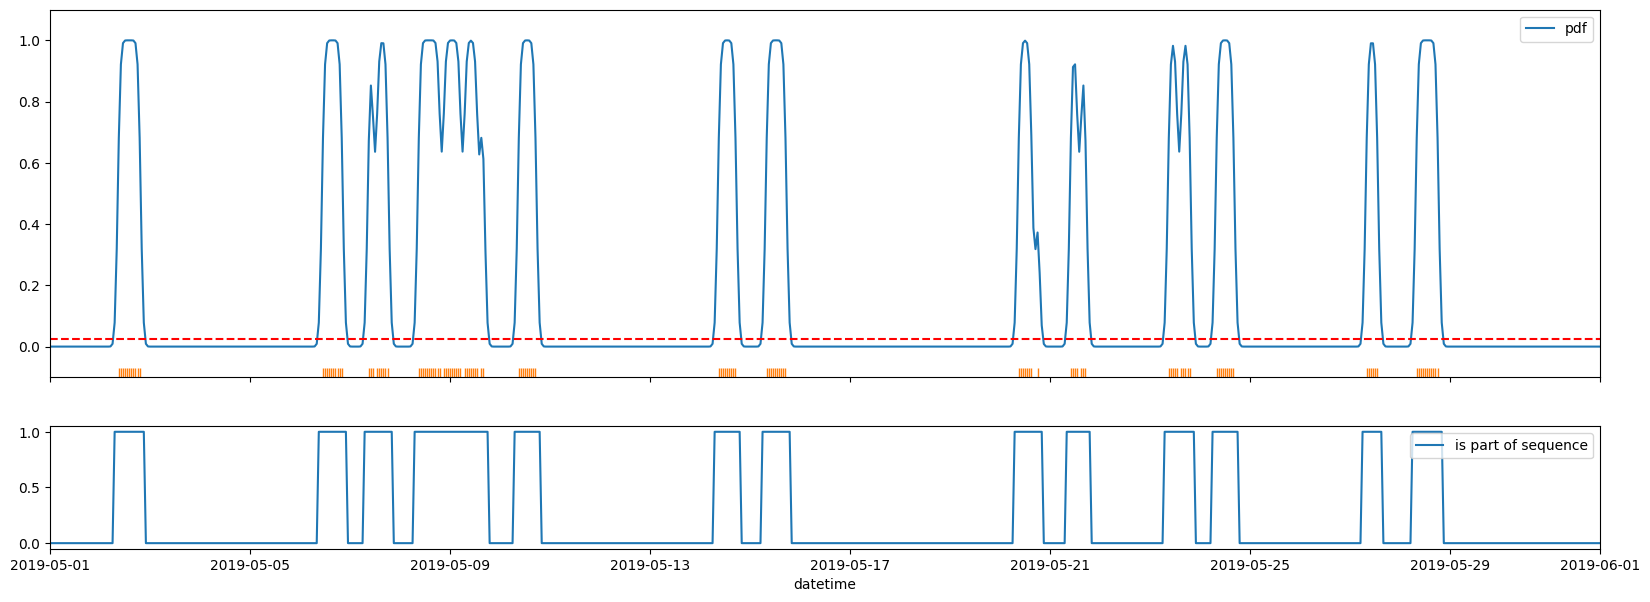

In [172]:
# visualize results
fig, axes = plt.subplots(2, 1, figsize=(20,7), sharex=True, gridspec_kw={'height_ratios': [3,1]})
sns.lineplot(x=df.datetime, y=scaled_pdf, ax=axes[0], label="pdf")
sns.rugplot(df[df.heating_temperature.notna()].datetime, ax=axes[0], label="temperature records")
axes[0].axhline(pdf_clipping_threshold, linestyle="--", color="red", label="pdf clipping threshold")
sns.lineplot(x=df.datetime, y=is_part_of_sequence, ax=axes[1], label="is part of sequence")
plt.xlim(datetime(2019,5,1), datetime(2019,6,1))
plt.legend()
plt.show()

In [169]:
# add results to the dataframe
df = (
    df
    .assign(is_part_of_sequence=is_part_of_sequence)
    .assign(sequence_label=sequence_label)
)
df.head()

,datetime,cooling_temperature,heating_temperature,is_part_of_sequence,sequence_label
0,2019-04-13 17:00:00+00:00,15.0,33.3,True,1.0
1,2019-04-13 18:00:00+00:00,NaN,34.0,True,1.0
2,2019-04-13 19:00:00+00:00,NaN,33.8,True,1.0
3,2019-04-13 20:00:00+00:00,NaN,34.2,True,1.0
4,2019-04-13 21:00:00+00:00,NaN,34.5,True,1.0


### Sequence conditioning

In [174]:
sequences = []
for sequence_label in df.sequence_label.dropna().unique():
    
    # extract sequence
    sequence = df[df.sequence_label == sequence_label]

    # trim leading and trailing NaNs
    sequence = sequence.loc[sequence.heating_temperature.first_valid_index():sequence.heating_temperature.last_valid_index()] # trim leading and trailing nan

    # interpolate missing values
    sequence.heating_temperature = sequence.heating_temperature.interpolate()

    # optionaly create features, for example run_time
    # sequence = sequence.assign(run_time=(sequence.datetime-sequence.datetime.min()) / np.timedelta64(1,'h') + 1)
    
    # adjust sequence span to full days
    new_index = pd.date_range(sequence.datetime.min().replace(hour=0), sequence.datetime.max().replace(hour=23), freq="H")
    sequence = sequence.set_index("datetime").reindex(new_index)
    sequence.heating_temperature = sequence.heating_temperature.fillna(0.0)

    sequences.append(sequence)

sequences = pd.concat(sequences)

### Anomaly detection via Hampel-filter

In [238]:
from hampel_filter import hampel_filter

In [254]:
filtered_heating_temperatures = hampel_filter(sequences.heating_temperature, 7, 3)

In [255]:
sequences = sequences.assign(is_anomaly_hampel= (filtered_heating_temperatures != sequences.heating_temperature))

In [256]:
# Visualize identified anomalies
px.scatter(data_frame=sequences[sequences.heating_temperature>0], y="heating_temperature", color="is_anomaly_hampel")

### Anomaly detection via Autoencoder

In [178]:
# create sliding windows
window_length = 24 # hours
X = np.lib.stride_tricks.sliding_window_view(sequences.heating_temperature, window_length)
X = np.expand_dims(X, axis=-1)
X.shape

(2041, 24, 1)

In [226]:
X_train, X_test = train_test_split(X, test_size=0.1)

In [188]:
autoencoder = keras.Sequential(
    [
        # encoder
        layers.Input(shape=(X.shape[1], X.shape[2])),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="linear"),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="linear"),

        # decoder
        layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="linear"),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="linear"),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same", activation="linear"),
    ]
)

autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 12, 32)            256       
                                                                 
 dropout_2 (Dropout)         (None, 12, 32)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 6, 16)             3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 12, 16)           1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 12, 16)            0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 24, 32)           3616      
 ranspose)                                            

In [190]:
history = autoencoder.fit(
    X_train,
    X_train,
    epochs=100,
    shuffle=True,
    batch_size=12,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, mode="min")
    ],
)

Epoch 1/100
123/123 [==============================] - 2s 7ms/step - loss: 212.4325 - val_loss: 98.6988
Epoch 2/100
123/123 [==============================] - 1s 4ms/step - loss: 86.7957 - val_loss: 59.1049
Epoch 3/100
123/123 [==============================] - 1s 5ms/step - loss: 59.8782 - val_loss: 40.1575
Epoch 4/100
123/123 [==============================] - 1s 5ms/step - loss: 46.7483 - val_loss: 30.0256
Epoch 5/100
123/123 [==============================] - 1s 6ms/step - loss: 39.3270 - val_loss: 24.4502
Epoch 6/100
123/123 [==============================] - 1s 5ms/step - loss: 34.7144 - val_loss: 20.5656
Epoch 7/100
123/123 [==============================] - 1s 6ms/step - loss: 30.7318 - val_loss: 17.3995
Epoch 8/100
123/123 [==============================] - 1s 5ms/step - loss: 27.7932 - val_loss: 15.1236
Epoch 9/100
123/123 [==============================] - 1s 6ms/step - loss: 25.5028 - val_loss: 13.8257
Epoch 10/100
123/123 [==============================] - 1s 5ms/step - lo

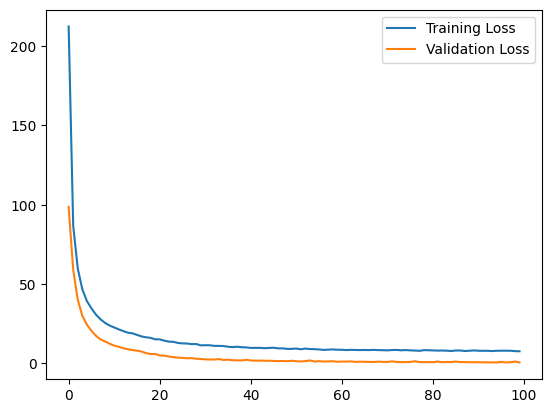

In [191]:
# Evaluate training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

58/58 [==============================] - 1s 4ms/step


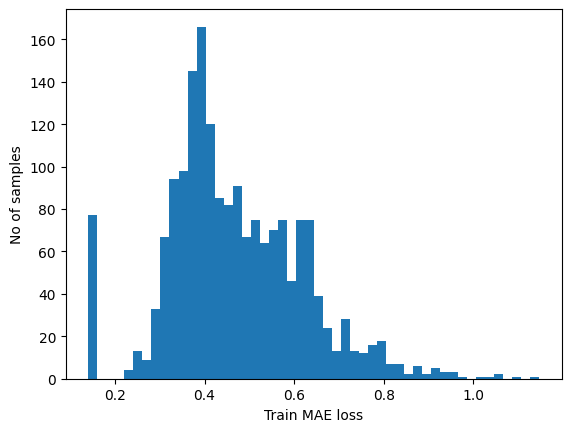

In [194]:
# Analyse train MAE loss.
X_train_pred = autoencoder.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [195]:
# Derive reconstruction threshold
reconstruction_threshold = np.std(train_mae_loss) * 5

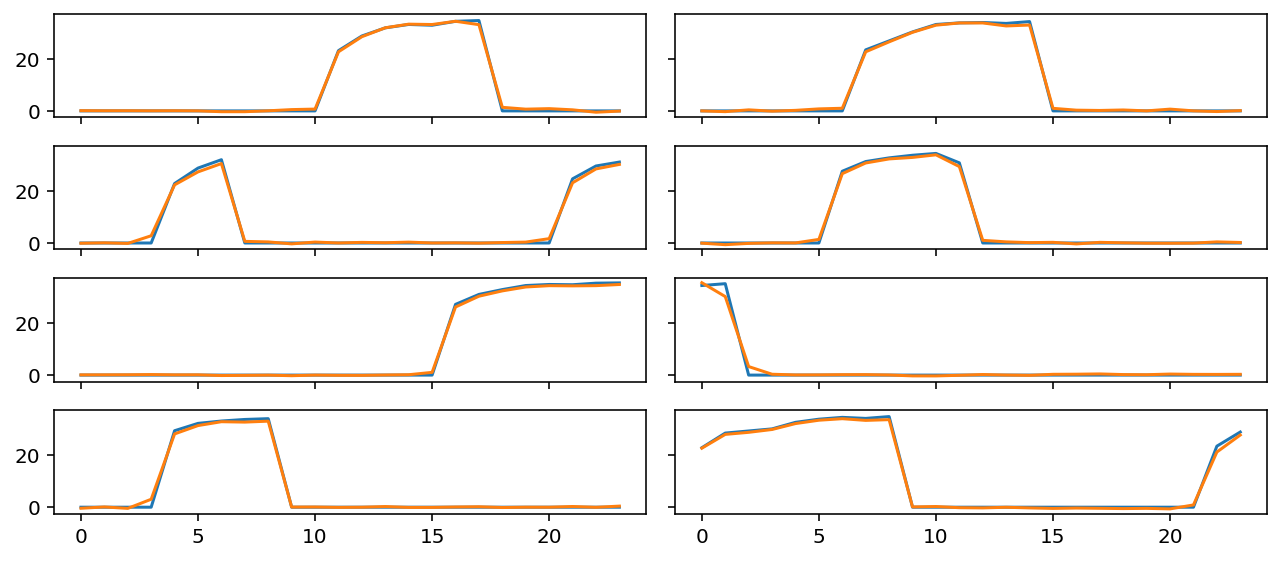

In [224]:
# Visual check random reconstructions
fig, axes =  plt.subplots(4, 2, figsize=(9,4), dpi=144, sharex=True, sharey=True)
axes = axes.flat
for i, sample in enumerate(random.sample(range(0,X_train.shape[0]), 8)):
    axes[i].plot(X_train[i], label="original")
    axes[i].plot(X_train_pred[i], label="reconstruction")
plt.tight_layout()
plt.show()

In [209]:
# Apply model for all data
X = sequences.heating_temperature.to_numpy().reshape((len(sequences)//24,24))
X_pred = autoencoder.predict(np.expand_dims(X, axis=-1)).squeeze()
original_heating_temperature = np.hstack(X)
reconstructed_heating_temperature = np.hstack(X_pred)

3/3 [==============================] - 0s 4ms/step


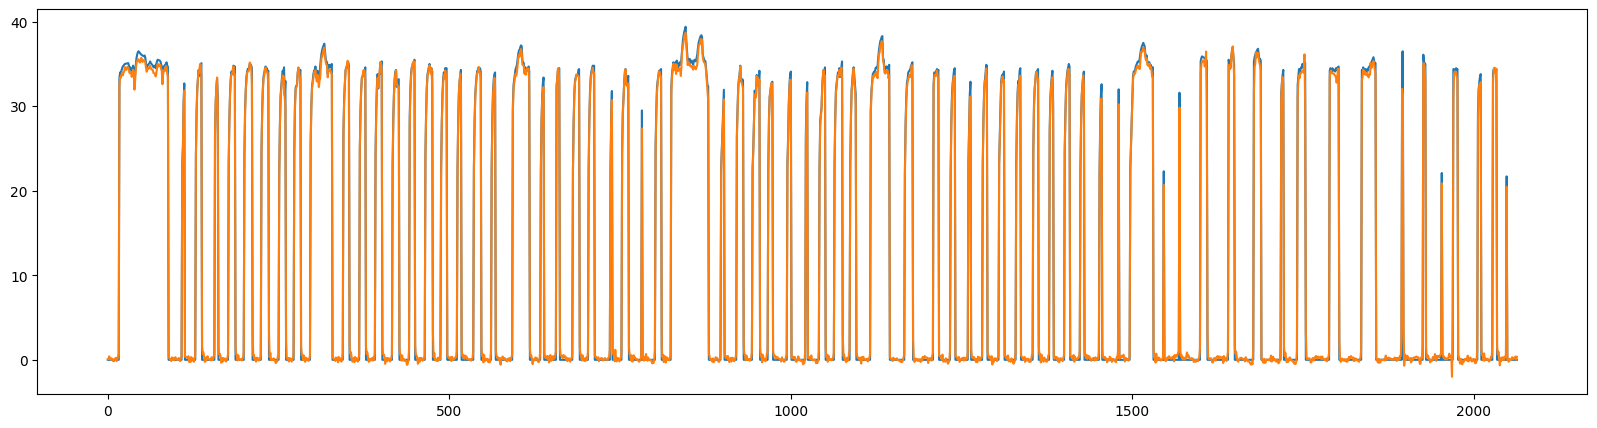

In [210]:
# Visualize reconstruction for all data
plt.figure(figsize=(20,5))
plt.plot(original_heating_temperature)
plt.plot(reconstructed_heating_temperature)
plt.show()

In [211]:
# Search anomalies based on reconstruction error
reconstruction_error = np.mean((X_pred - X)**2,axis=1)
is_anomaly = reconstruction_error > reconstruction_threshold

In [213]:
# update dataframe
sequences = sequences.assign(is_anomaly=is_anomaly.repeat(24))

In [228]:
# Visualize identified anomalies
px.scatter(data_frame=sequences[sequences.heating_temperature>0], y="heating_temperature", color="is_anomaly")